In [530]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import xgboost as xgb
from xgboost.sklearn import (XGBClassifier,
                        XGBRegressor)

from sklearn.metrics import (r2_score,
                            mean_squared_error,
                            mean_absolute_error,
                            median_absolute_error,
                            roc_auc_score, auc,
                            classification_report,
                            confusion_matrix,
                            roc_curve)

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# from sklearn.feature_extraction.text import TfidVectorizer
from sklearn.feature_selection import (mutual_info_classif,
                                      mutual_info_regression)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import (KFold, train_test_split)

import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK

In [531]:
#from preprocess_features import*
# from visual_functions import*
# from hyperparameter_tuning import*

In [357]:
import warnings
warnings.filterwarnings('ignore')

In [358]:
sns.set_style('whitegrid')

In [359]:
# Load csv
train_data = pd.read_csv('Training_Clean_DataSet.csv')
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6298 entries, 0 to 6297
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ListingID        6298 non-null   int64  
 1   Seller City      6298 non-null   object 
 2   Seller Is Priv   6298 non-null   bool   
 3   Seller List Src  6296 non-null   object 
 4   Seller Name      6298 non-null   object 
 5   Seller Rating    6298 non-null   float64
 6   Seller Rev Cnt   6298 non-null   int64  
 7   Seller State     6298 non-null   object 
 8   Seller Zip       6296 non-null   float64
 9   Body style       6298 non-null   object 
 10  Certified        6298 non-null   bool   
 11  Color Ext        6225 non-null   object 
 12  Color Int        5570 non-null   object 
 13  Drive Train      5897 non-null   object 
 14  Engine           5937 non-null   object 
 15  Feats            6023 non-null   object 
 16  Fuel             6296 non-null   object 
 17  History       

In [360]:
train_data = train_data.set_index('ListingID')

In [361]:
train_data.head()

,Seller City,Seller Is Priv,Seller List Src,Seller Name,Seller Rating,Seller Rev Cnt,Seller State,Seller Zip,Body style,Certified,...,Make,Mileage,Model,Price Label,Seller Notes,Type,Transmission,Year,Trim,Listing Price
ListingID,,,,,,,,,,,,,,,,,,,,,
3287,Warren,False,Inventory Command Center,Prime Motorz,5.0,32,MI,48091.0,SUV,False,...,Jeep,39319.0,Grand Cherokee,Fair Price,NaN,Used,Automatic 8-Speed,2015,High Altitude,30990.0
3920,Fargo,False,Cadillac Certified Program,Gateway Chevrolet Cadillac,4.8,1456,ND,58103.0,SUV,True,...,Cadillac,30352.0,XT5,Good Deal,Come take a look at our great pre-owned invent...,Used,NaN,2017,NaN,34860.0
4777,Waukesha,False,Jeep Certified Program,Wilde Chrysler Jeep Dodge Ram &amp; Subaru,4.8,1405,WI,53186.0,SUV,True,...,Jeep,38957.0,Grand Cherokee,Good Deal,Backed by a rigorous 125-point inspection by f...,Used,8-Speed Automatic w/OD,2015,Laredo,23249.0
6242,Wentzville,False,Inventory Command Center,Century Dodge Chrysler Jeep RAM,4.4,21,MO,63385.0,SUV,False,...,Jeep,20404.0,Grand Cherokee,Good Deal,Drop by to see us and you will quickly see how...,Used,Automatic,2018,Limited,31977.0
7108,Fayetteville,False,HomeNet Automotive,Superior Buick GMC of Fayetteville,3.7,74,AR,72703.0,SUV,False,...,Cadillac,19788.0,XT5,Good Deal,"Luxury, Exterior Parking Camera Rear, Front Du...",Used,8-Speed Automatic,2018,Luxury,33495.0


In [362]:
train_data.columns = train_data.columns.str.lower()

In [363]:
# Split Independent and Dependent Variables
y = train_data[['trim', 'listing price']]
y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6298 entries, 3287 to 8620012
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   trim           5893 non-null   object 
 1   listing price  6246 non-null   float64
dtypes: float64(1), object(1)
memory usage: 147.6+ KB


In [364]:
y.isna().sum()

trim             405
listing price     52
dtype: int64

In [365]:
# Impute missing value
X = train_data.drop(y.columns, axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6298 entries, 3287 to 8620012
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   seller city      6298 non-null   object 
 1   seller is priv   6298 non-null   bool   
 2   seller list src  6296 non-null   object 
 3   seller name      6298 non-null   object 
 4   seller rating    6298 non-null   float64
 5   seller rev cnt   6298 non-null   int64  
 6   seller state     6298 non-null   object 
 7   seller zip       6296 non-null   float64
 8   body style       6298 non-null   object 
 9   certified        6298 non-null   bool   
 10  color ext        6225 non-null   object 
 11  color int        5570 non-null   object 
 12  drive train      5897 non-null   object 
 13  engine           5937 non-null   object 
 14  feats            6023 non-null   object 
 15  fuel             6296 non-null   object 
 16  history          6097 non-null   object 
 17  list days    

In [366]:
X.isna().sum()

seller city          0
seller is priv       0
seller list src      2
seller name          0
seller rating        0
seller rev cnt       0
seller state         0
seller zip           2
body style           0
certified            0
color ext           73
color int          728
drive train        401
engine             361
feats              275
fuel                 2
history            201
list days            2
make                 0
mileage              2
model                0
price label        285
seller notes       243
type                 0
transmission       197
year                 0
dtype: int64

In [367]:
# Observe, Clean, Transform. Starting Dependent Variables
y.head()

,trim,listing price
ListingID,,
3287,High Altitude,30990.0
3920,NaN,34860.0
4777,Laredo,23249.0
6242,Limited,31977.0
7108,Luxury,33495.0


In [368]:
# Cleaning trim. Simplify with most similar groups
y['trim'].value_counts()

trim
Limited                             1912
Premium Luxury                       747
Laredo                               704
Luxury                               645
Overland                             381
Altitude                             325
Summit                               242
Trailhawk                            178
Base                                 159
Platinum                             131
High Altitude                         86
SRT                                   76
Luxury FWD                            53
FWD                                   49
Laredo E                              47
Premium Luxury FWD                    35
Trackhawk                             30
Sterling Edition                      26
Luxury AWD                            22
Platinum AWD                          13
Premium Luxury AWD                     9
75th Anniversary                       8
Limited 75th Anniversary Edition       5
SRT Night                              3
Upland     

In [369]:
# Show which make has "Luxury"
train_data.loc[y['trim'].str.lower().str.contains('luxury') == True, 'make'].value_counts()

make
Cadillac    1511
Name: count, dtype: int64

In [370]:
# Show which make has "Limited"
train_data.loc[y['trim'].str.lower().str.contains('limited') == True, 'make'].value_counts()

make
Jeep    1920
Name: count, dtype: int64

In [371]:
# Show which make has "Laredo"
train_data.loc[y['trim'].str.lower().str.contains('laredo') == True, 'make'].value_counts()

make
Jeep    751
Name: count, dtype: int64

In [372]:
# Show which make has "Front Wheel Drive"
train_data.loc[y['trim'].str.lower().str.contains('fwd') == True, 'make'].value_counts()

make
Cadillac    137
Name: count, dtype: int64

In [373]:
# Show which make has "All Wheel Drive"
train_data.loc[y['trim'].str.lower().str.contains('awd') == True, 'make'].value_counts()

make
Cadillac    44
Name: count, dtype: int64

In [374]:
# Display whats there
train_data['make'].value_counts()

make
Jeep        4199
Cadillac    2099
Name: count, dtype: int64

In [375]:
# Display which trim belongs to maker
train_data.groupby('make')['trim'].value_counts()

make      trim                            
Cadillac  Premium Luxury                       747
          Luxury                               645
          Base                                 159
          Platinum                             131
          Luxury FWD                            53
          FWD                                   49
          Premium Luxury FWD                    35
          Luxury AWD                            22
          Platinum AWD                          13
          Premium Luxury AWD                     9
Jeep      Limited                             1912
          Laredo                               704
          Overland                             381
          Altitude                             325
          Summit                               242
          Trailhawk                            178
          High Altitude                         86
          SRT                                   76
          Laredo E                     

In [376]:
# Display better maker by splitting Jeep and Cadillac
c_data = train_data[train_data['make'] == 'Cadillac']
c_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2099 entries, 3920 to 8617378
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   seller city      2099 non-null   object 
 1   seller is priv   2099 non-null   bool   
 2   seller list src  2099 non-null   object 
 3   seller name      2099 non-null   object 
 4   seller rating    2099 non-null   float64
 5   seller rev cnt   2099 non-null   int64  
 6   seller state     2099 non-null   object 
 7   seller zip       2099 non-null   float64
 8   body style       2099 non-null   object 
 9   certified        2099 non-null   bool   
 10  color ext        2072 non-null   object 
 11  color int        1782 non-null   object 
 12  drive train      1925 non-null   object 
 13  engine           1929 non-null   object 
 14  feats            1863 non-null   object 
 15  fuel             2099 non-null   object 
 16  history          2085 non-null   object 
 17  list days    

In [377]:
j_data = train_data[train_data['make'] == 'Jeep']
j_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4199 entries, 3287 to 8620012
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   seller city      4199 non-null   object 
 1   seller is priv   4199 non-null   bool   
 2   seller list src  4197 non-null   object 
 3   seller name      4199 non-null   object 
 4   seller rating    4199 non-null   float64
 5   seller rev cnt   4199 non-null   int64  
 6   seller state     4199 non-null   object 
 7   seller zip       4197 non-null   float64
 8   body style       4199 non-null   object 
 9   certified        4199 non-null   bool   
 10  color ext        4153 non-null   object 
 11  color int        3788 non-null   object 
 12  drive train      3972 non-null   object 
 13  engine           4008 non-null   object 
 14  feats            4160 non-null   object 
 15  fuel             4197 non-null   object 
 16  history          4012 non-null   object 
 17  list days    

In [378]:
trim_mapping = {
    'premium': ['premium luxury', 'premium luxury fwd', 'premium luxury awd'],
    'luxury': ['luxury', 'luxury fwd', 'luxury awd'],
    'base': ['base'],
    'platinum': ['platinum', 'platinum awd']
}

In [379]:
# Function to map trims based on the mapping dictionary
def map_trims(trim):
    for category, trim_list in trim_mapping.items():
        if trim in trim_list:
            return category
    return trim

In [380]:
# Apply the mapping function to the 'trim' column
c_data['cleaned_trim'] = c_data['trim'].apply(map_trims)

In [381]:
# Drop rows where 'cleaned_trim' is 'fwd'
c_data_cleaned = c_data[c_data['trim'] != 'fwd']

In [382]:
# Use groupby to group by the 'make' and 'cleaned_trim' columns and count the occurrences
grouped_counts = c_data_cleaned.groupby(['trim'])

In [383]:
c_data.loc[c_data['trim'].str.lower().str.contains('premium') == True, 'trim'] = 'premium'
c_data.loc[c_data['trim'].str.lower().str.contains('luxury') == True, 'trim'] = 'luxury'
c_data.loc[c_data['trim'].str.lower().str.contains('base') == True, 'trim'] = 'base'
c_data.loc[c_data['trim'].str.lower().str.contains('platinum') == True, 'trim'] = 'platinum'

In [384]:
# c_data['trim'].value_counts().sort_values().plot.barh()

In [385]:
c_data['trim'].value_counts()

trim
premium     791
luxury      720
base        159
platinum    144
FWD          49
Name: count, dtype: int64

In [386]:
c_data = c_data[c_data['trim'] != 'FWD']
c_data['trim'].value_counts()

trim
premium     791
luxury      720
base        159
platinum    144
Name: count, dtype: int64

In [387]:
j_data.loc[j_data['trim'].str.lower().str.contains('limited') == True, 'trim'] = 'limited'
j_data.loc[j_data['trim'].str.lower().str.contains('laredo') == True, 'trim'] = 'laredo'
j_data.loc[j_data['trim'].str.lower().str.contains('srt') == True, 'trim'] = 'srt'

In [388]:
j_data['cleaned_trim'] = j_data['trim'].apply(map_trims)

In [389]:
j_data_cleaned = j_data[j_data['trim'] != 'fwd']

In [390]:
grouped_counts = j_data_cleaned.groupby(['trim'])

<Axes: ylabel='trim'>

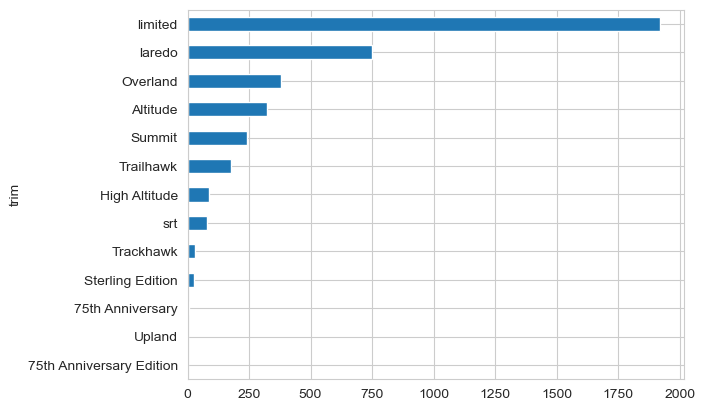

In [391]:
j_data['trim'].value_counts().sort_values().plot.barh()

In [392]:
# Removing data after Trackhawk
keep_trims = ['limited', 'laredo', 'overland', 'altitude', 'summit', 'trailhawk', 'high altitude', 'srt', 'trackhawk']
j_data = j_data.loc[j_data['trim'].str.lower().isin(keep_trims), :]
j_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3992 entries, 3287 to 8620012
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   seller city      3992 non-null   object 
 1   seller is priv   3992 non-null   bool   
 2   seller list src  3990 non-null   object 
 3   seller name      3992 non-null   object 
 4   seller rating    3992 non-null   float64
 5   seller rev cnt   3992 non-null   int64  
 6   seller state     3992 non-null   object 
 7   seller zip       3990 non-null   float64
 8   body style       3992 non-null   object 
 9   certified        3992 non-null   bool   
 10  color ext        3966 non-null   object 
 11  color int        3697 non-null   object 
 12  drive train      3933 non-null   object 
 13  engine           3969 non-null   object 
 14  feats            3976 non-null   object 
 15  fuel             3990 non-null   object 
 16  history          3805 non-null   object 
 17  list days    

In [393]:
j_data['trim'].value_counts()

trim
limited          1920
laredo            751
Overland          381
Altitude          325
Summit            242
Trailhawk         178
High Altitude      86
srt                79
Trackhawk          30
Name: count, dtype: int64

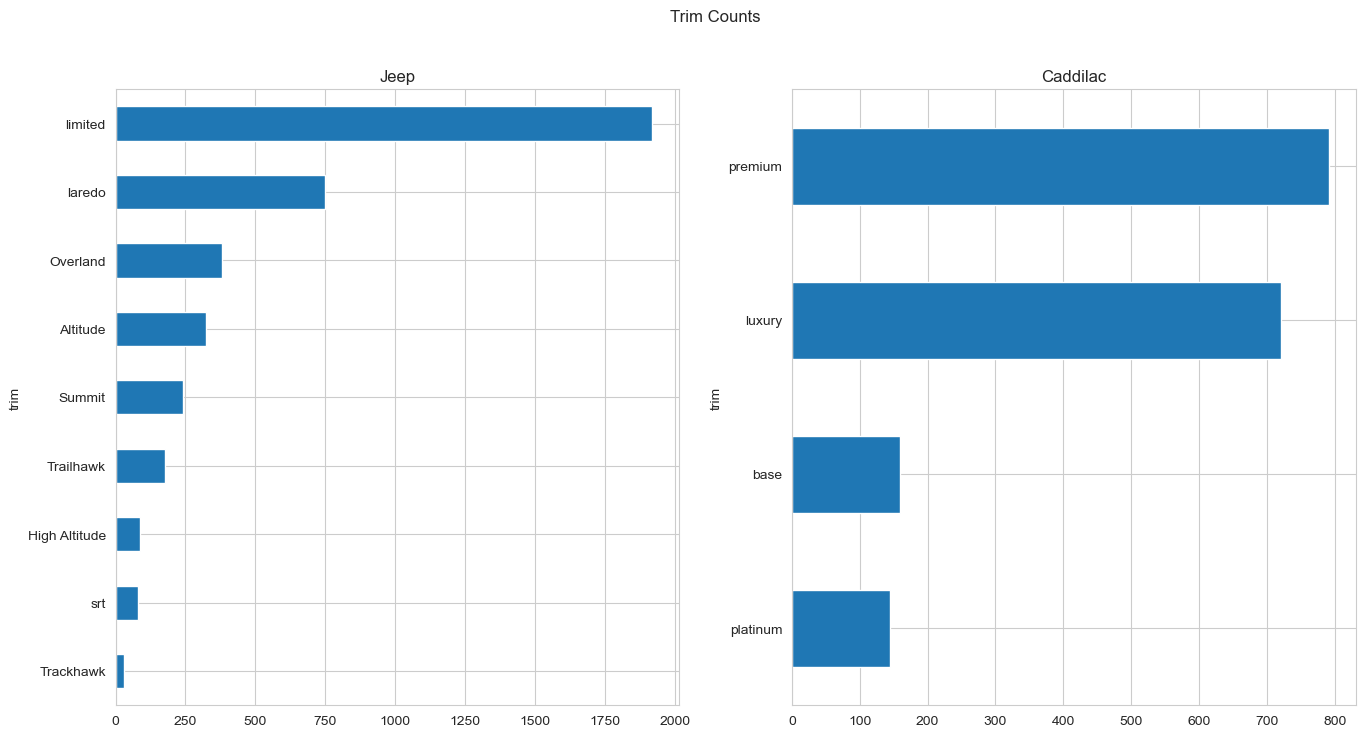

In [394]:
fig, axes = plt.subplots(ncols=2, figsize=(16,8))
j_data['trim'].value_counts().sort_values().plot.barh(ax=axes[0])
axes[0].set_title('Jeep')
c_data['trim'].value_counts().sort_values().plot.barh(ax=axes[1])
axes[1].set_title('Caddilac')
fig.suptitle('Trim Counts')
fig.savefig('trim_counts.png');

In [395]:
# Oginizing the price of dealer

y['listing price'].isna().sum()

52

Text(0.5, 1.0, 'Listing Price Issued')

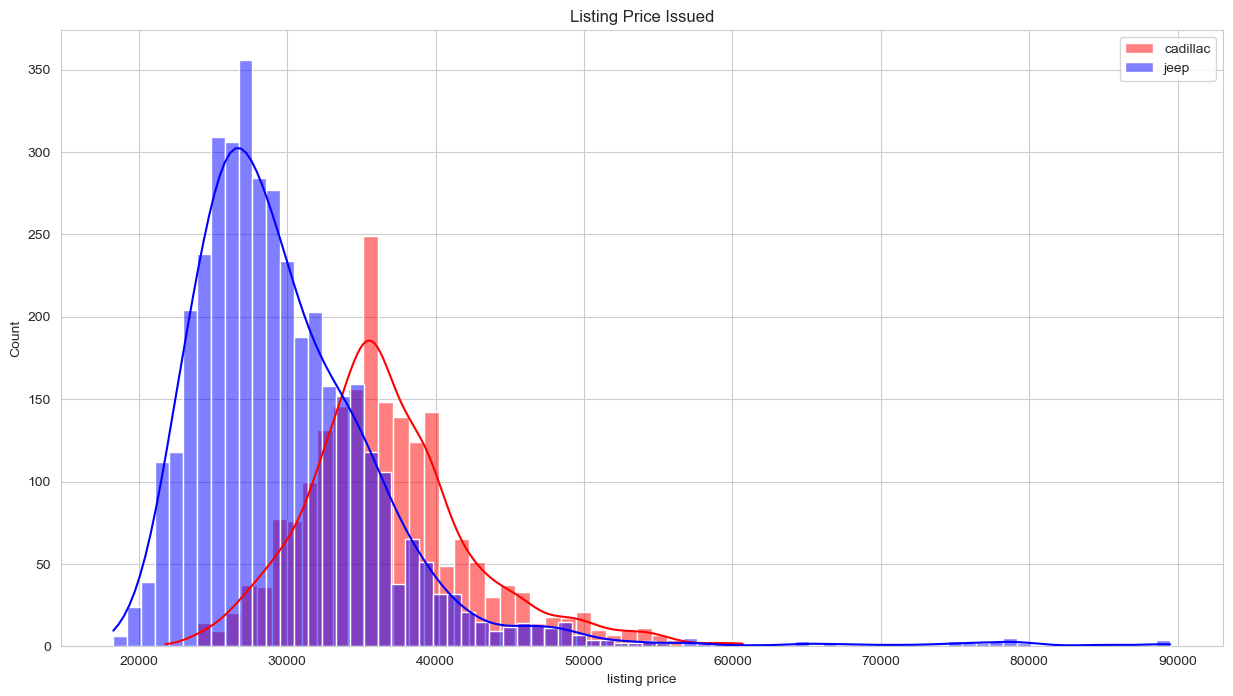

In [396]:
fig, ax = plt.subplots(figsize=(15,8))
sns.histplot(c_data['listing price'], kde=True, color='red', ax=ax, label='cadillac')
sns.histplot(j_data['listing price'], kde=True, color='blue', ax=ax, label='jeep')
ax.legend()
ax.set_title('Listing Price Issued')

In [397]:
# Define Quick Scale to use temperature for QQ Plot
def quick_scale(series):
    return series.sub(np.mean(series)).div(np.std(series))

Text(0.5, 1.0, 'QQ Plot Jeep listing price')

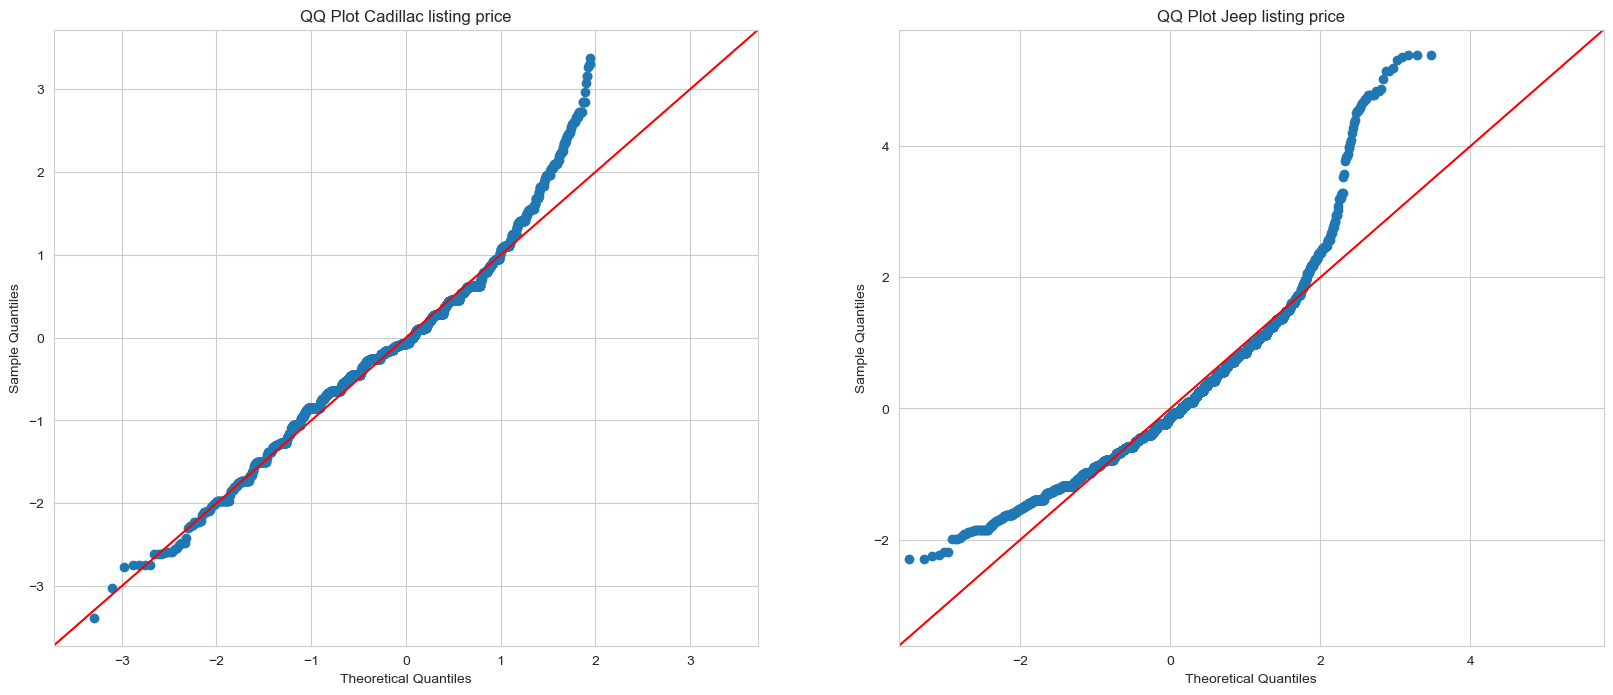

In [398]:
fig, axes = plt.subplots(ncols=2, figsize=(20,8))
temp = quick_scale(np.log(c_data['listing price']))
sm.qqplot(temp, line='45', ax=axes[0])
axes[0].set_title('QQ Plot Cadillac listing price')

temp = quick_scale(np.log(j_data['listing price']))
sm.qqplot(temp, line='45', ax=axes[1])
axes[1].set_title('QQ Plot Jeep listing price')

In [399]:
c_data.loc[:, 'listing price'] = np.log(c_data.loc[:, 'listing price'])
j_data.loc[:, 'listing price'] = np.log(j_data.loc[:, 'listing price'])

In [400]:
# Independent Features
train_data = pd.concat([j_data, c_data])
train_data.dropna(inplace=True)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4965 entries, 4777 to 8617378
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   seller city      4965 non-null   object 
 1   seller is priv   4965 non-null   bool   
 2   seller list src  4965 non-null   object 
 3   seller name      4965 non-null   object 
 4   seller rating    4965 non-null   float64
 5   seller rev cnt   4965 non-null   int64  
 6   seller state     4965 non-null   object 
 7   seller zip       4965 non-null   float64
 8   body style       4965 non-null   object 
 9   certified        4965 non-null   bool   
 10  color ext        4965 non-null   object 
 11  color int        4965 non-null   object 
 12  drive train      4965 non-null   object 
 13  engine           4965 non-null   object 
 14  feats            4965 non-null   object 
 15  fuel             4965 non-null   object 
 16  history          4965 non-null   object 
 17  list days    

In [401]:
test_index =np.random.choice(train_data.index,
                            size=train_data.index.size // 5,
                            replace=False)
train_index = train_data.index[[i not in test_index for i in train_data.index]]
train_data, test_data = train_data.loc[train_index,:].copy(), train_data.loc[test_index,:].copy()

In [497]:
categorical_feature = []
numeric_features = []
drop_features = []
data_cols = train_data.columns[:5]
data_cols

Index(['ListingID', 'Seller City', 'Seller Is Priv', 'Seller List Src',
       'Seller Name'],
      dtype='object')

In [498]:
i = 0
temp = train_data[data_cols[i]].copy()
temp.head()

0    3287
1    3920
2    4777
3    6242
4    7108
Name: ListingID, dtype: int64

In [499]:
(temp.value_counts() / temp.size).head(10)

ListingID
3287       0.000159
5780500    0.000159
5779657    0.000159
5778762    0.000159
5778758    0.000159
5777772    0.000159
5777650    0.000159
5776922    0.000159
5776335    0.000159
5772737    0.000159
Name: count, dtype: float64

In [500]:
# Remove City Columns
drop_features.append(data_cols[i])
i += 1

In [501]:
temp = train_data[data_cols[i]].copy()
temp.head(), temp.value_counts()

(0          Warren
 1           Fargo
 2        Waukesha
 3      Wentzville
 4    Fayetteville
 Name: Seller City, dtype: object,
 Seller City
 Chicago          118
 Battle Creek     103
 Columbus          63
 Louisville        59
 Houston           53
                 ... 
 Big Stone Gap      1
 Delmont            1
 Gulfport           1
 Shreveport         1
 Virginia           1
 Name: count, Length: 1318, dtype: int64)

In [502]:
drop_features.append(data_cols[i])
i += 1

In [503]:
temp = train_data[data_cols[i]].copy()
temp.head(), temp.value_counts()

(0    False
 1    False
 2    False
 3    False
 4    False
 Name: Seller Is Priv, dtype: bool,
 Seller Is Priv
 False    6284
 True       14
 Name: count, dtype: int64)

In [504]:
temp.value_counts() / temp.size

Seller Is Priv
False    0.997777
True     0.002223
Name: count, dtype: float64

In [505]:
temp = train_data[data_cols[i]].copy()
temp.head()

0    False
1    False
2    False
3    False
4    False
Name: Seller Is Priv, dtype: bool

In [506]:
temp.value_counts() / temp.size

Seller Is Priv
False    0.997777
True     0.002223
Name: count, dtype: float64

In [507]:
drop_features.append(data_cols[i])
i += 1

In [508]:
temp = train_data[data_cols[i]].copy()
temp.head()

0      Inventory Command Center
1    Cadillac Certified Program
2        Jeep Certified Program
3      Inventory Command Center
4            HomeNet Automotive
Name: Seller List Src, dtype: object

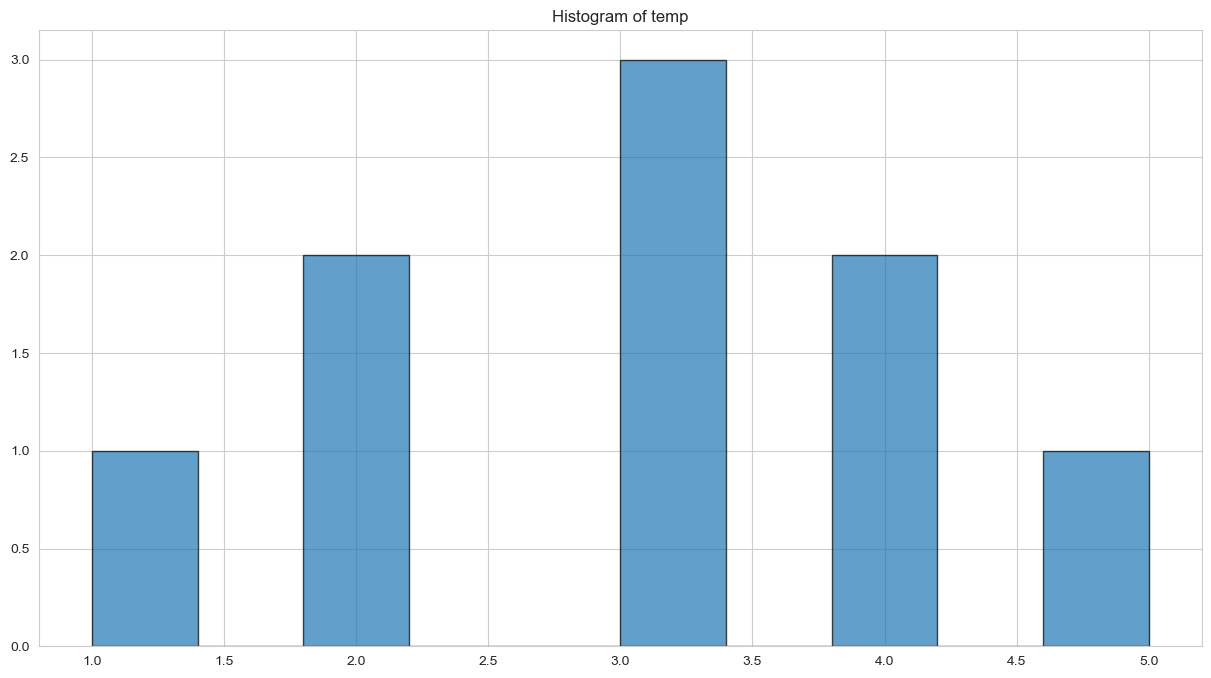

In [509]:
temp = pd.Series([1, 2, 2, 3, 3, 3, 4, 4, 5])

fig, ax = plt.subplots(figsize=(15, 8))
ax.hist(temp, bins=10, edgecolor='black', alpha=0.7)
ax.set_title('Histogram of temp')

plt.show()

In [528]:
features = train_data.iloc[:, :-3]
target1 = train_data['Trim']
target2 = train_data['Listing Price']

In [532]:
from sklearn.preprocessing import LabelEncoder

# Trim the Model
trim_encoder = LabelEncoder()
target1_coded = trim_encoder.fit_transform(target1.values)

In [553]:
print(x_train.shape)

(5038,)


In [560]:
# Assuming x_train is a one-dimensional array
num_samples = x_train.shape[0]  # Number of samples

# Reshape x_train into a 2D array with one column
x_train = x_train.reshape((num_samples, 1))

In [555]:
num_samples, num_features = x_train.shape

In [556]:
x_train = x_train.reshape((num_samples, num_features))

In [541]:
print(target1.unique())

['High Altitude' nan 'Laredo' 'Limited' 'Luxury' 'Limited 4x4' 'Altitude'
 'Overland' 'Premium Luxury' 'Base' 'Summit' 'FWD' 'SRT' 'Luxury AWD'
 'Trailhawk' 'Sterling Edition' 'Platinum' 'Laredo E' 'Luxury FWD'
 'Trackhawk' '75th Anniversary' 'Premium Luxury FWD' 'Platinum AWD'
 'SRT Night' 'Limited 75th Anniversary Edition' '75th Anniversary Edition'
 'Limited 75th Anniversary' 'Premium Luxury AWD' 'Upland' 'Limited X']
